# Text Sentiment Classification

Classification of the sentiment in [IMDB movie reviews](https://ai.stanford.edu/~amaas/data/sentiment/) with a Logistic Regression on a TF-IDF matrix.

<a id='index'></a>
## Index

- [Data preprocessing](#preprocessing)
- [Training a classifier](#classifier)
- [Validation](#validation)

<a id='preprocessing'></a>
## Data preprocessing

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

from sklearn.externals import joblib
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

from validation import plot_confusion_matrix, visualise_predictions
from preprocessing import preprocess, clean, tokenize, tokenize_n_stem, tokenize_n_lemmatize

In [3]:
IMDB_MOVIE_REVIEWS_ROOT = 'aclImdb'

train_data, test_data = preprocess(IMDB_MOVIE_REVIEWS_ROOT)

print("Number of training examples: %d" % len(train_data))
print("Number of test examples: %d\n" % len(test_data))

print("The first 5 reviews from the training set:\n")
print(train_data.head(5))

print("\nThe first 5 reviews from the test set:\n")
print(test_data.head(5))

Number of training examples: 25000
Number of test examples: 25000

The first 5 reviews from the training set:

                                              review  sentiment
0  I was skimming over the list of films of Richa...          0
1  I cringed all the way through this movie. Firs...          0
2  This movie displayed more racial hatred of Jew...          0
3  All I can say is, before watching the movie I ...          0
4  This is easily the worst Presley vehicle ever,...          0

The first 5 reviews from the test set:

                                              review  sentiment
0  Jerry Lewis was marginally funny when he didn'...          0
1  I wish Depardieu had been able to finish his b...          0
2  4 Oscar winners, Karl Malden, Sally Field, Shi...          0
3  This movie was disturbing, not because of the ...          0
4  This movie is so dull I spent half of it on IM...          0


In [4]:
# Get the shortest review
raw_review = min(train_data['review'].values, key=len)

print("%s\n" % raw_review)

# Test tokenize function
print("%r\n" % tokenize(clean(raw_review)))

# Test tokenize_n_stem function
print("%r\n" % tokenize_n_stem(clean(raw_review)))

# Test tokenize_n_lemmatize function
print("%r\n" % tokenize_n_lemmatize(clean(raw_review)))

This movie is terrible but it has some good effects.

['movie', 'terrible', 'good', 'effects']

['movi', 'terribl', 'good', 'effect']

['movie', 'terrible', 'good', 'effect']



<a id='classifier'></a>
## Training a classifier

[back to index](#index)

Grid Search is combined with cross-validation (k = 10) to identify the best combination parameters.

- Documentation for GridSearchCV can be found [here](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
- Documentation for Pipeline can be found [here](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)
- Documentation for TfidfVectorizer can be found [here](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)
- Documentation for LogisticRegression can be found [here](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [5]:
RANDOM_STATE = 7

vectorizer = TfidfVectorizer()
classifier = LogisticRegression(random_state=RANDOM_STATE)

pipeline = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

params = [{
    'vectorizer__tokenizer' : [tokenize, tokenize_n_stem],
    'vectorizer__max_df' : [0.8, 1.0],
    'classifier__C' : [1.0, 10.0, 100.0],
    'classifier__penalty' : ['l1', 'l2']
}]

grid_search = GridSearchCV(
    pipeline,
    params,
    scoring='accuracy',
    cv=10,
    n_jobs=3
)

grid_search.fit(train_data['review'].values, train_data['sentiment'].values)

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=Tr...nalty='l2', random_state=7, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=3,
       param_grid=[{'vectorizer__tokenizer': [<function tokenize at 0x7f6572d91510>, <function tokenize_n_stem at 0x7f6572d91598>], 'classifier__C': [1.0, 10.0, 100.0], 'classifier__penalty': ['l1', 'l2'], 'vectorizer__max_df': [0.8, 1.0]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

<a id='validation'></a>
## Validation

[back to index](#index)

Best parameters set found on development set:

 {'classifier__C': 10.0, 'vectorizer__tokenizer': <function tokenize at 0x7f6572d91510>, 'classifier__penalty': 'l2', 'vectorizer__max_df': 0.8}

CV score: 89.75%
Test score: 87.85%

Test classification report:


             precision    recall  f1-score   support

          0       0.87      0.89      0.88     12500
          1       0.89      0.87      0.88     12500

avg / total       0.88      0.88      0.88     25000



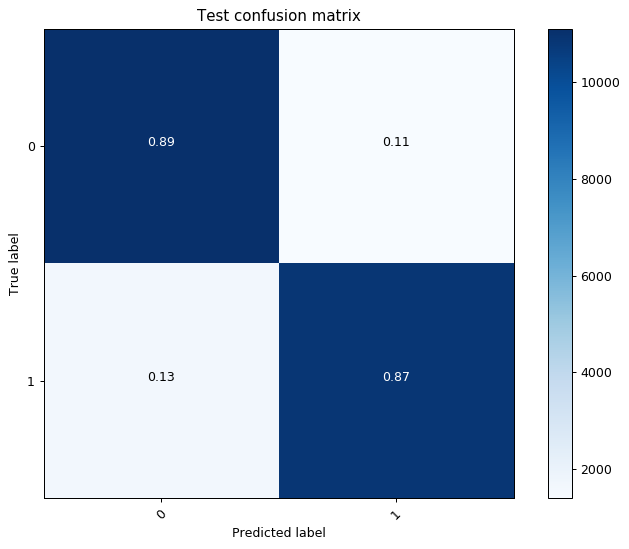

In [6]:
best_classifier = grid_search.best_estimator_

best_params = grid_search.best_params_
y_test_hat = best_classifier.predict(test_data['review'].values)

print("Best parameters set found on development set:\n\n", best_params)

print("\nCV score: %.2f%%" % (grid_search.best_score_ * 100))
print("Test score: %.2f%%" % (best_classifier.score(test_data['review'].values, test_data['sentiment'].values) * 100))

print("\nTest classification report:\n\n")
print(classification_report(test_data['sentiment'].values, y_test_hat))

plot_confusion_matrix(test_data['sentiment'], y_test_hat, title='Test confusion matrix')
#visualise_predictions(test_data['review'].values, test_data['sentiment'].values, y_test_hat)

In [7]:
# Pickle the best classifier
save_to_dir = 'best_classifier'
if not os.path.exists(save_to_dir):
    os.mkdir(save_to_dir)
joblib.dump(best_classifier, '%s/tfidf_logreg_pipeline.pkl' % save_to_dir, compress=1)

['best_classifier/tfidf_logreg_pipeline.pkl']